# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [14]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

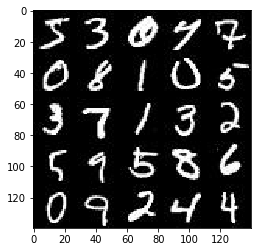

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

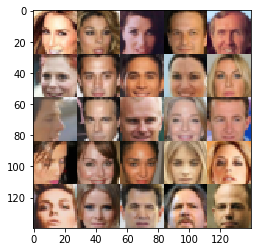

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    #mark_used()
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\Users\\rahulkgup\\myschool\\softwares\\Anaconda3\\envs\\tensorflow\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\Users\\rahulkgup\\myschool\\softwares\\Anaconda3\\envs\\tensorflow\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\Users\\rahulkgup\\myschool\\softwares\\Anaconda3\\envs\\tensorflow\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "C:\\Users\\rahulkgup\\myschool\\softwares\\Anaconda3\\envs\\tensorflow\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\Users\\rahulkgup\\myschool\\softwares\

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [16]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 0.8
    rate = 1 - keep_prob
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input 28x28x3
        
        c1 = tf.layers.conv2d(images, filters=64, kernel_size=(5,5), strides=(2,2), padding='SAME', 
                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())        
        relu1 = tf.maximum(alpha * c1, c1)
        relu1 = tf.layers.dropout(relu1, rate=rate)
        
        # 14X14x64
        
        c2 = tf.layers.conv2d(c1, filters=128, kernel_size=(5,5), strides=(2,2), padding='SAME', 
                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn2 = tf.layers.batch_normalization(c2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.layers.dropout(relu2, rate=rate)

        # 7x7x128
        
        c3 = tf.layers.conv2d(c2, filters=256, kernel_size=(5,5), strides=(2,2), padding='SAME', 
                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())       
        bn3 = tf.layers.batch_normalization(c3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.layers.dropout(relu3, rate=rate)
        
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)        
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [25]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 0.8
    rate = 1 - keep_prob
    
    with tf.variable_scope('generator', reuse=not is_train):
        # Project input vector
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape to start convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        x1 = tf.nn.relu(x1)
        x1 = tf.layers.dropout(x1, rate=rate, training=is_train)

        # 2x2x512
        
        x2 = tf.layers.conv2d_transpose(x1, filters=256, kernel_size=(5,5), strides=(2,2), padding='VALID',
                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        #x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.nn.relu(x2)
        x2 = tf.layers.dropout(x2, rate=rate, training=is_train)
        
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=(5,5), strides=(2,2), padding='SAME',
                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        #x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.nn.relu(x3)
        x3 = tf.layers.dropout(x3, rate=rate, training=is_train)
        
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=(5,5), strides=(2,2), padding='SAME',
                    kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        # 28x28x3
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [26]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_faked = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_faked, reuse=True)
    
    # Add smoothing to reduce labels
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=(tf.ones_like(d_model_real) * 0.9)
        )
    )
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)
        )
    )
    
    d_loss = d_loss_fake + d_loss_real
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=(tf.ones_like(d_model_fake))
        )
    )
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [27]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [28]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [29]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    images_count, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Change the range from (-0.5, 0.5) to (-1, 1) to be consistent with batch_z
                batch_images *= 2
                #print("Min/Max: {} / {}".format(np.min(batch_images), np.max(batch_images)))
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % 10 == 0:
                    # Get the losses and print them out after each 10 steps
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 50, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.6186... Generator Loss: 0.4351
Epoch 1/2... Discriminator Loss: 0.5081... Generator Loss: 2.9054
Epoch 1/2... Discriminator Loss: 0.6260... Generator Loss: 1.4932
Epoch 1/2... Discriminator Loss: 0.3763... Generator Loss: 3.6441
Epoch 1/2... Discriminator Loss: 0.4526... Generator Loss: 2.3956
Epoch 1/2... Discriminator Loss: 0.3634... Generator Loss: 3.9564
Epoch 1/2... Discriminator Loss: 0.3948... Generator Loss: 2.9089
Epoch 1/2... Discriminator Loss: 0.4022... Generator Loss: 2.7578
Epoch 1/2... Discriminator Loss: 0.3899... Generator Loss: 3.2408
Epoch 1/2... Discriminator Loss: 0.3922... Generator Loss: 3.2218


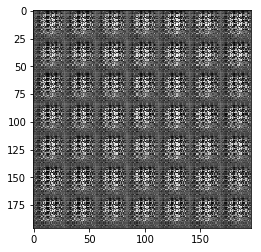

Epoch 1/2... Discriminator Loss: 0.3706... Generator Loss: 3.6671
Epoch 1/2... Discriminator Loss: 0.6720... Generator Loss: 6.0133
Epoch 1/2... Discriminator Loss: 0.6108... Generator Loss: 1.5462
Epoch 1/2... Discriminator Loss: 1.2842... Generator Loss: 9.0247
Epoch 1/2... Discriminator Loss: 0.9545... Generator Loss: 7.5948
Epoch 1/2... Discriminator Loss: 0.7433... Generator Loss: 1.3669
Epoch 1/2... Discriminator Loss: 0.5704... Generator Loss: 2.2961
Epoch 1/2... Discriminator Loss: 0.4917... Generator Loss: 2.8938
Epoch 1/2... Discriminator Loss: 0.4374... Generator Loss: 2.6764
Epoch 1/2... Discriminator Loss: 0.5476... Generator Loss: 1.8897


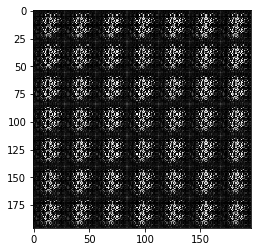

Epoch 1/2... Discriminator Loss: 0.3822... Generator Loss: 3.7919
Epoch 1/2... Discriminator Loss: 0.4062... Generator Loss: 3.3088
Epoch 1/2... Discriminator Loss: 0.4125... Generator Loss: 3.2117
Epoch 1/2... Discriminator Loss: 0.4538... Generator Loss: 2.8011
Epoch 1/2... Discriminator Loss: 0.4728... Generator Loss: 2.5010
Epoch 1/2... Discriminator Loss: 0.3986... Generator Loss: 3.5286
Epoch 1/2... Discriminator Loss: 0.4039... Generator Loss: 3.2386
Epoch 1/2... Discriminator Loss: 0.5006... Generator Loss: 2.1967
Epoch 1/2... Discriminator Loss: 0.4721... Generator Loss: 2.6653
Epoch 1/2... Discriminator Loss: 0.4433... Generator Loss: 3.0026


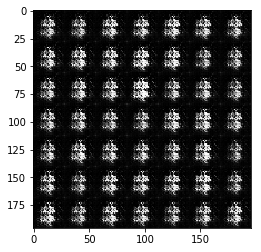

Epoch 1/2... Discriminator Loss: 0.4130... Generator Loss: 3.6977
Epoch 1/2... Discriminator Loss: 0.4268... Generator Loss: 2.7132
Epoch 1/2... Discriminator Loss: 0.4369... Generator Loss: 2.5925
Epoch 1/2... Discriminator Loss: 0.4488... Generator Loss: 3.4802
Epoch 1/2... Discriminator Loss: 0.4707... Generator Loss: 2.9798
Epoch 1/2... Discriminator Loss: 0.4504... Generator Loss: 2.6200
Epoch 1/2... Discriminator Loss: 0.4622... Generator Loss: 2.5122
Epoch 1/2... Discriminator Loss: 0.4539... Generator Loss: 3.7073
Epoch 1/2... Discriminator Loss: 0.4311... Generator Loss: 2.9384
Epoch 1/2... Discriminator Loss: 0.4447... Generator Loss: 2.6253


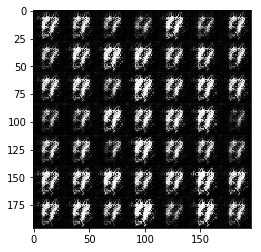

Epoch 1/2... Discriminator Loss: 0.4520... Generator Loss: 4.2190
Epoch 1/2... Discriminator Loss: 0.4938... Generator Loss: 2.9309
Epoch 1/2... Discriminator Loss: 0.4663... Generator Loss: 2.8719
Epoch 1/2... Discriminator Loss: 0.4360... Generator Loss: 3.2846
Epoch 1/2... Discriminator Loss: 0.5166... Generator Loss: 2.7480
Epoch 1/2... Discriminator Loss: 0.4448... Generator Loss: 3.1350
Epoch 1/2... Discriminator Loss: 0.4040... Generator Loss: 3.4512
Epoch 1/2... Discriminator Loss: 0.4540... Generator Loss: 2.9247
Epoch 1/2... Discriminator Loss: 0.4348... Generator Loss: 3.5865
Epoch 1/2... Discriminator Loss: 0.4694... Generator Loss: 2.3666


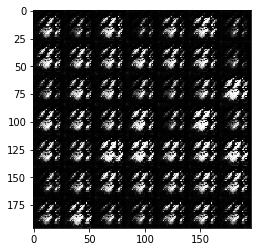

Epoch 1/2... Discriminator Loss: 0.4070... Generator Loss: 3.5388
Epoch 1/2... Discriminator Loss: 0.4214... Generator Loss: 3.1807
Epoch 1/2... Discriminator Loss: 0.4501... Generator Loss: 2.7054
Epoch 1/2... Discriminator Loss: 0.4242... Generator Loss: 3.1474
Epoch 1/2... Discriminator Loss: 0.4041... Generator Loss: 3.0304
Epoch 1/2... Discriminator Loss: 0.5316... Generator Loss: 2.0892
Epoch 1/2... Discriminator Loss: 0.3947... Generator Loss: 3.8368
Epoch 1/2... Discriminator Loss: 0.4136... Generator Loss: 3.3457
Epoch 1/2... Discriminator Loss: 0.4361... Generator Loss: 3.3500
Epoch 1/2... Discriminator Loss: 0.4687... Generator Loss: 2.6684


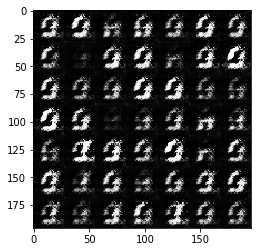

Epoch 1/2... Discriminator Loss: 0.4313... Generator Loss: 3.2084
Epoch 1/2... Discriminator Loss: 0.4470... Generator Loss: 3.1237
Epoch 1/2... Discriminator Loss: 0.4735... Generator Loss: 2.7207
Epoch 1/2... Discriminator Loss: 0.5205... Generator Loss: 2.3341
Epoch 1/2... Discriminator Loss: 0.5115... Generator Loss: 2.9976
Epoch 1/2... Discriminator Loss: 0.4918... Generator Loss: 2.6939
Epoch 1/2... Discriminator Loss: 0.4453... Generator Loss: 2.7819
Epoch 1/2... Discriminator Loss: 0.4595... Generator Loss: 2.9275
Epoch 1/2... Discriminator Loss: 0.4320... Generator Loss: 3.1273
Epoch 1/2... Discriminator Loss: 0.4082... Generator Loss: 3.4470


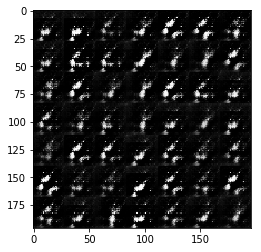

Epoch 1/2... Discriminator Loss: 0.4184... Generator Loss: 3.3718
Epoch 1/2... Discriminator Loss: 0.4184... Generator Loss: 3.2683
Epoch 1/2... Discriminator Loss: 0.4258... Generator Loss: 3.3099
Epoch 1/2... Discriminator Loss: 0.4207... Generator Loss: 3.3666
Epoch 1/2... Discriminator Loss: 0.4467... Generator Loss: 2.8968
Epoch 1/2... Discriminator Loss: 0.4228... Generator Loss: 3.0643
Epoch 1/2... Discriminator Loss: 0.5805... Generator Loss: 1.8692
Epoch 1/2... Discriminator Loss: 0.4699... Generator Loss: 3.3939
Epoch 1/2... Discriminator Loss: 0.4600... Generator Loss: 2.6873
Epoch 1/2... Discriminator Loss: 0.4752... Generator Loss: 2.9213


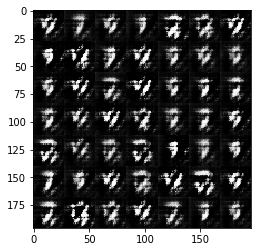

Epoch 1/2... Discriminator Loss: 0.5097... Generator Loss: 2.4318
Epoch 1/2... Discriminator Loss: 0.5109... Generator Loss: 2.5930
Epoch 1/2... Discriminator Loss: 0.4872... Generator Loss: 2.9450
Epoch 1/2... Discriminator Loss: 0.4855... Generator Loss: 2.4373
Epoch 1/2... Discriminator Loss: 0.4795... Generator Loss: 4.0070
Epoch 1/2... Discriminator Loss: 0.4996... Generator Loss: 5.0500
Epoch 1/2... Discriminator Loss: 0.4777... Generator Loss: 3.4130
Epoch 1/2... Discriminator Loss: 0.4837... Generator Loss: 2.8312
Epoch 1/2... Discriminator Loss: 0.5785... Generator Loss: 3.1899
Epoch 1/2... Discriminator Loss: 0.5841... Generator Loss: 2.8355


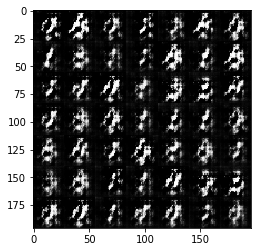

Epoch 1/2... Discriminator Loss: 0.5541... Generator Loss: 2.5180
Epoch 1/2... Discriminator Loss: 0.7045... Generator Loss: 1.8512
Epoch 1/2... Discriminator Loss: 0.4584... Generator Loss: 3.1814
Epoch 1/2... Discriminator Loss: 0.4932... Generator Loss: 2.8824
Epoch 1/2... Discriminator Loss: 0.6151... Generator Loss: 2.0559
Epoch 2/2... Discriminator Loss: 0.5243... Generator Loss: 2.4948
Epoch 2/2... Discriminator Loss: 0.5837... Generator Loss: 1.9843
Epoch 2/2... Discriminator Loss: 0.6148... Generator Loss: 3.6639
Epoch 2/2... Discriminator Loss: 0.5202... Generator Loss: 2.5109
Epoch 2/2... Discriminator Loss: 0.5164... Generator Loss: 2.6929


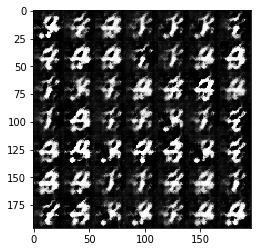

Epoch 2/2... Discriminator Loss: 0.5865... Generator Loss: 1.9250
Epoch 2/2... Discriminator Loss: 0.4926... Generator Loss: 2.8252
Epoch 2/2... Discriminator Loss: 0.6219... Generator Loss: 1.8083
Epoch 2/2... Discriminator Loss: 0.7139... Generator Loss: 1.6268
Epoch 2/2... Discriminator Loss: 0.5336... Generator Loss: 3.2220
Epoch 2/2... Discriminator Loss: 0.5338... Generator Loss: 2.8010
Epoch 2/2... Discriminator Loss: 0.6172... Generator Loss: 2.0248
Epoch 2/2... Discriminator Loss: 0.5323... Generator Loss: 2.6940
Epoch 2/2... Discriminator Loss: 0.6355... Generator Loss: 2.1805
Epoch 2/2... Discriminator Loss: 0.7431... Generator Loss: 1.3899


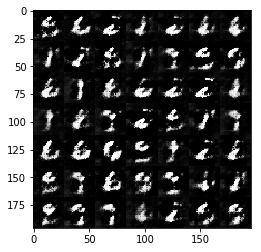

Epoch 2/2... Discriminator Loss: 0.4530... Generator Loss: 3.1674
Epoch 2/2... Discriminator Loss: 0.5815... Generator Loss: 1.9546
Epoch 2/2... Discriminator Loss: 0.5250... Generator Loss: 2.3200
Epoch 2/2... Discriminator Loss: 0.6512... Generator Loss: 1.7897
Epoch 2/2... Discriminator Loss: 0.6056... Generator Loss: 2.4306
Epoch 2/2... Discriminator Loss: 0.6000... Generator Loss: 3.0550
Epoch 2/2... Discriminator Loss: 0.8826... Generator Loss: 3.9878
Epoch 2/2... Discriminator Loss: 0.5125... Generator Loss: 3.0482
Epoch 2/2... Discriminator Loss: 0.6988... Generator Loss: 2.0630
Epoch 2/2... Discriminator Loss: 0.5503... Generator Loss: 2.4440


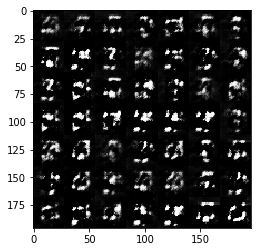

Epoch 2/2... Discriminator Loss: 0.5211... Generator Loss: 3.1556
Epoch 2/2... Discriminator Loss: 0.5636... Generator Loss: 2.4621
Epoch 2/2... Discriminator Loss: 0.6293... Generator Loss: 3.1119
Epoch 2/2... Discriminator Loss: 0.6515... Generator Loss: 2.0219
Epoch 2/2... Discriminator Loss: 0.6084... Generator Loss: 2.0690
Epoch 2/2... Discriminator Loss: 0.5960... Generator Loss: 2.1494
Epoch 2/2... Discriminator Loss: 0.5794... Generator Loss: 2.4862
Epoch 2/2... Discriminator Loss: 0.5157... Generator Loss: 3.6715
Epoch 2/2... Discriminator Loss: 0.6632... Generator Loss: 1.8147
Epoch 2/2... Discriminator Loss: 0.7689... Generator Loss: 1.4694


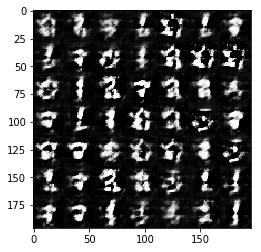

Epoch 2/2... Discriminator Loss: 0.6742... Generator Loss: 2.0630
Epoch 2/2... Discriminator Loss: 0.7798... Generator Loss: 1.5643
Epoch 2/2... Discriminator Loss: 0.6849... Generator Loss: 1.9671
Epoch 2/2... Discriminator Loss: 0.7968... Generator Loss: 1.6331
Epoch 2/2... Discriminator Loss: 0.6888... Generator Loss: 2.0371
Epoch 2/2... Discriminator Loss: 0.5737... Generator Loss: 2.5272
Epoch 2/2... Discriminator Loss: 0.5491... Generator Loss: 2.7545
Epoch 2/2... Discriminator Loss: 0.5368... Generator Loss: 2.5013
Epoch 2/2... Discriminator Loss: 0.7664... Generator Loss: 2.5120
Epoch 2/2... Discriminator Loss: 0.6547... Generator Loss: 1.8171


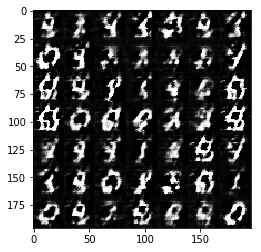

Epoch 2/2... Discriminator Loss: 0.7359... Generator Loss: 1.7953
Epoch 2/2... Discriminator Loss: 0.6454... Generator Loss: 2.1497
Epoch 2/2... Discriminator Loss: 0.7459... Generator Loss: 1.6431
Epoch 2/2... Discriminator Loss: 0.6494... Generator Loss: 2.0715
Epoch 2/2... Discriminator Loss: 0.7683... Generator Loss: 1.8084
Epoch 2/2... Discriminator Loss: 0.9591... Generator Loss: 1.3390
Epoch 2/2... Discriminator Loss: 0.7285... Generator Loss: 3.2420
Epoch 2/2... Discriminator Loss: 0.8644... Generator Loss: 1.5464
Epoch 2/2... Discriminator Loss: 0.7813... Generator Loss: 1.6758
Epoch 2/2... Discriminator Loss: 0.6481... Generator Loss: 1.8236


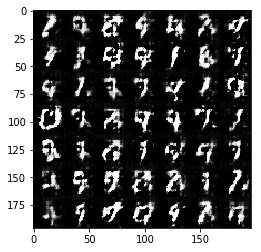

Epoch 2/2... Discriminator Loss: 0.6872... Generator Loss: 2.1859
Epoch 2/2... Discriminator Loss: 0.8290... Generator Loss: 1.7894
Epoch 2/2... Discriminator Loss: 0.6898... Generator Loss: 1.8692
Epoch 2/2... Discriminator Loss: 0.6195... Generator Loss: 1.9230
Epoch 2/2... Discriminator Loss: 0.6846... Generator Loss: 2.4732
Epoch 2/2... Discriminator Loss: 0.5943... Generator Loss: 2.3171
Epoch 2/2... Discriminator Loss: 0.8136... Generator Loss: 1.4126
Epoch 2/2... Discriminator Loss: 0.7056... Generator Loss: 1.6886
Epoch 2/2... Discriminator Loss: 0.7245... Generator Loss: 2.4300
Epoch 2/2... Discriminator Loss: 0.7086... Generator Loss: 1.5803


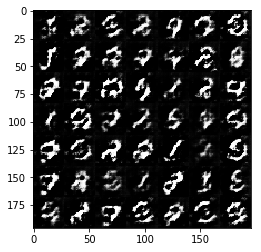

Epoch 2/2... Discriminator Loss: 0.6744... Generator Loss: 2.0790
Epoch 2/2... Discriminator Loss: 0.6761... Generator Loss: 1.9068
Epoch 2/2... Discriminator Loss: 0.7007... Generator Loss: 1.9424
Epoch 2/2... Discriminator Loss: 0.7052... Generator Loss: 2.1007
Epoch 2/2... Discriminator Loss: 0.6746... Generator Loss: 2.5243
Epoch 2/2... Discriminator Loss: 0.8835... Generator Loss: 2.4147
Epoch 2/2... Discriminator Loss: 0.8797... Generator Loss: 1.5097
Epoch 2/2... Discriminator Loss: 0.9490... Generator Loss: 1.1635
Epoch 2/2... Discriminator Loss: 0.6548... Generator Loss: 3.5048
Epoch 2/2... Discriminator Loss: 0.8844... Generator Loss: 1.7714


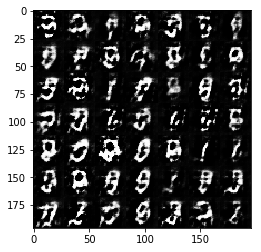

Epoch 2/2... Discriminator Loss: 0.7439... Generator Loss: 1.8593
Epoch 2/2... Discriminator Loss: 1.0795... Generator Loss: 1.0899
Epoch 2/2... Discriminator Loss: 0.6377... Generator Loss: 2.5410
Epoch 2/2... Discriminator Loss: 0.8443... Generator Loss: 1.9062
Epoch 2/2... Discriminator Loss: 0.8335... Generator Loss: 1.6770
Epoch 2/2... Discriminator Loss: 0.8905... Generator Loss: 1.2444
Epoch 2/2... Discriminator Loss: 0.6659... Generator Loss: 2.3159
Epoch 2/2... Discriminator Loss: 0.5978... Generator Loss: 2.3443
Epoch 2/2... Discriminator Loss: 0.7491... Generator Loss: 1.9041
Epoch 2/2... Discriminator Loss: 0.6992... Generator Loss: 2.1442


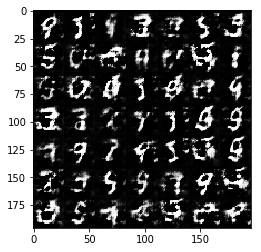

Epoch 2/2... Discriminator Loss: 0.8160... Generator Loss: 1.4885
Epoch 2/2... Discriminator Loss: 0.8549... Generator Loss: 1.7931
Epoch 2/2... Discriminator Loss: 0.7975... Generator Loss: 1.7821
Epoch 2/2... Discriminator Loss: 0.7918... Generator Loss: 2.0192
Epoch 2/2... Discriminator Loss: 0.9098... Generator Loss: 1.4371
Epoch 2/2... Discriminator Loss: 0.8148... Generator Loss: 2.1437
Epoch 2/2... Discriminator Loss: 0.8422... Generator Loss: 1.6732
Epoch 2/2... Discriminator Loss: 0.7524... Generator Loss: 1.7574
Epoch 2/2... Discriminator Loss: 0.8197... Generator Loss: 1.5347
Epoch 2/2... Discriminator Loss: 0.6601... Generator Loss: 1.9948


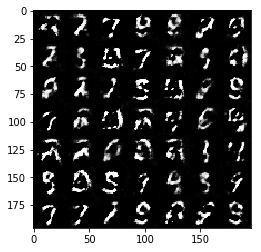

In [30]:
batch_size = 63
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5267... Generator Loss: 2.1144
Epoch 1/1... Discriminator Loss: 0.6723... Generator Loss: 1.8054
Epoch 1/1... Discriminator Loss: 0.4911... Generator Loss: 2.1312
Epoch 1/1... Discriminator Loss: 0.4644... Generator Loss: 2.3612
Epoch 1/1... Discriminator Loss: 0.4692... Generator Loss: 2.4031
Epoch 1/1... Discriminator Loss: 0.4669... Generator Loss: 2.3477
Epoch 1/1... Discriminator Loss: 0.4225... Generator Loss: 2.9191
Epoch 1/1... Discriminator Loss: 0.4375... Generator Loss: 2.9577
Epoch 1/1... Discriminator Loss: 0.5286... Generator Loss: 2.1045
Epoch 1/1... Discriminator Loss: 0.4352... Generator Loss: 2.5885


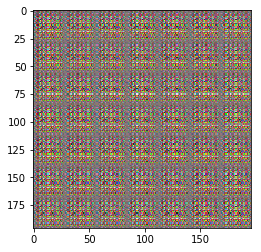

Epoch 1/1... Discriminator Loss: 0.4058... Generator Loss: 2.7942
Epoch 1/1... Discriminator Loss: 0.4072... Generator Loss: 2.9062
Epoch 1/1... Discriminator Loss: 0.3917... Generator Loss: 3.1807
Epoch 1/1... Discriminator Loss: 0.3824... Generator Loss: 3.2185
Epoch 1/1... Discriminator Loss: 0.4116... Generator Loss: 2.8340
Epoch 1/1... Discriminator Loss: 0.3756... Generator Loss: 3.4764
Epoch 1/1... Discriminator Loss: 0.3999... Generator Loss: 3.3417
Epoch 1/1... Discriminator Loss: 0.4186... Generator Loss: 4.2112
Epoch 1/1... Discriminator Loss: 0.4149... Generator Loss: 3.2179
Epoch 1/1... Discriminator Loss: 0.5015... Generator Loss: 2.0675


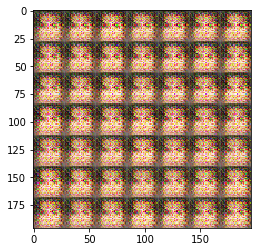

Epoch 1/1... Discriminator Loss: 0.5055... Generator Loss: 3.5722
Epoch 1/1... Discriminator Loss: 0.5154... Generator Loss: 2.6013
Epoch 1/1... Discriminator Loss: 0.5341... Generator Loss: 2.1604
Epoch 1/1... Discriminator Loss: 0.4681... Generator Loss: 2.8682
Epoch 1/1... Discriminator Loss: 0.4382... Generator Loss: 2.6043
Epoch 1/1... Discriminator Loss: 0.4060... Generator Loss: 3.7302
Epoch 1/1... Discriminator Loss: 0.3951... Generator Loss: 3.6560
Epoch 1/1... Discriminator Loss: 0.4290... Generator Loss: 3.9366
Epoch 1/1... Discriminator Loss: 0.4221... Generator Loss: 3.2784
Epoch 1/1... Discriminator Loss: 0.4101... Generator Loss: 3.1124


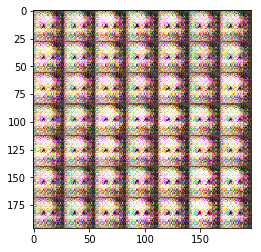

Epoch 1/1... Discriminator Loss: 0.4196... Generator Loss: 2.8219
Epoch 1/1... Discriminator Loss: 0.8032... Generator Loss: 1.0946
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 4.2752
Epoch 1/1... Discriminator Loss: 0.6494... Generator Loss: 3.2308
Epoch 1/1... Discriminator Loss: 0.6232... Generator Loss: 2.3534
Epoch 1/1... Discriminator Loss: 0.8423... Generator Loss: 1.0972
Epoch 1/1... Discriminator Loss: 0.6861... Generator Loss: 3.3202
Epoch 1/1... Discriminator Loss: 0.5448... Generator Loss: 2.3297
Epoch 1/1... Discriminator Loss: 0.5451... Generator Loss: 2.1373
Epoch 1/1... Discriminator Loss: 0.5405... Generator Loss: 2.1890


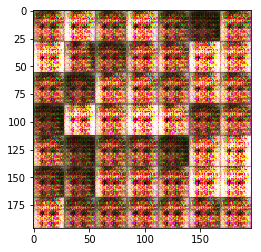

Epoch 1/1... Discriminator Loss: 0.4277... Generator Loss: 2.9891
Epoch 1/1... Discriminator Loss: 0.5057... Generator Loss: 2.4179
Epoch 1/1... Discriminator Loss: 0.4697... Generator Loss: 2.4229
Epoch 1/1... Discriminator Loss: 0.6456... Generator Loss: 1.6838
Epoch 1/1... Discriminator Loss: 0.5444... Generator Loss: 2.5232
Epoch 1/1... Discriminator Loss: 0.5152... Generator Loss: 2.0423
Epoch 1/1... Discriminator Loss: 0.7643... Generator Loss: 1.2687
Epoch 1/1... Discriminator Loss: 0.5110... Generator Loss: 2.3281
Epoch 1/1... Discriminator Loss: 0.4761... Generator Loss: 2.9545
Epoch 1/1... Discriminator Loss: 0.5263... Generator Loss: 2.1578


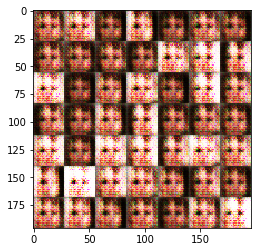

Epoch 1/1... Discriminator Loss: 0.4751... Generator Loss: 2.5076
Epoch 1/1... Discriminator Loss: 0.7359... Generator Loss: 4.2474
Epoch 1/1... Discriminator Loss: 0.6275... Generator Loss: 1.5561
Epoch 1/1... Discriminator Loss: 0.5826... Generator Loss: 1.6266
Epoch 1/1... Discriminator Loss: 0.4659... Generator Loss: 2.7849
Epoch 1/1... Discriminator Loss: 0.5171... Generator Loss: 2.1329
Epoch 1/1... Discriminator Loss: 0.4277... Generator Loss: 3.4553
Epoch 1/1... Discriminator Loss: 0.5504... Generator Loss: 1.9836
Epoch 1/1... Discriminator Loss: 0.5324... Generator Loss: 2.0978
Epoch 1/1... Discriminator Loss: 0.4720... Generator Loss: 3.3000


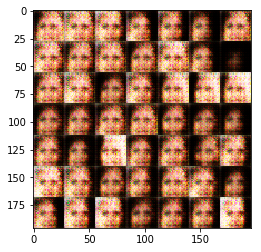

Epoch 1/1... Discriminator Loss: 0.4536... Generator Loss: 3.0772
Epoch 1/1... Discriminator Loss: 0.4730... Generator Loss: 2.4530
Epoch 1/1... Discriminator Loss: 0.6479... Generator Loss: 4.4622
Epoch 1/1... Discriminator Loss: 0.4581... Generator Loss: 2.6770
Epoch 1/1... Discriminator Loss: 0.4437... Generator Loss: 3.1137
Epoch 1/1... Discriminator Loss: 0.4470... Generator Loss: 2.8326
Epoch 1/1... Discriminator Loss: 0.5364... Generator Loss: 2.2155
Epoch 1/1... Discriminator Loss: 0.4836... Generator Loss: 2.9096
Epoch 1/1... Discriminator Loss: 0.5877... Generator Loss: 3.8201
Epoch 1/1... Discriminator Loss: 0.6655... Generator Loss: 1.5211


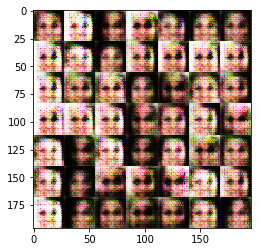

Epoch 1/1... Discriminator Loss: 0.4359... Generator Loss: 3.1671
Epoch 1/1... Discriminator Loss: 0.4620... Generator Loss: 3.1140
Epoch 1/1... Discriminator Loss: 0.5520... Generator Loss: 2.0167
Epoch 1/1... Discriminator Loss: 0.5535... Generator Loss: 2.9189
Epoch 1/1... Discriminator Loss: 0.5190... Generator Loss: 2.1081
Epoch 1/1... Discriminator Loss: 0.4802... Generator Loss: 2.5018
Epoch 1/1... Discriminator Loss: 0.4701... Generator Loss: 3.7175
Epoch 1/1... Discriminator Loss: 0.5067... Generator Loss: 2.2290
Epoch 1/1... Discriminator Loss: 0.5716... Generator Loss: 1.8740
Epoch 1/1... Discriminator Loss: 0.5330... Generator Loss: 3.1788


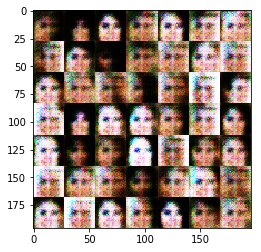

Epoch 1/1... Discriminator Loss: 0.5936... Generator Loss: 1.9432
Epoch 1/1... Discriminator Loss: 0.5227... Generator Loss: 2.9431
Epoch 1/1... Discriminator Loss: 0.5730... Generator Loss: 1.9816
Epoch 1/1... Discriminator Loss: 0.6178... Generator Loss: 1.6111
Epoch 1/1... Discriminator Loss: 0.5266... Generator Loss: 2.2633
Epoch 1/1... Discriminator Loss: 0.6630... Generator Loss: 1.5743
Epoch 1/1... Discriminator Loss: 0.6205... Generator Loss: 2.7395
Epoch 1/1... Discriminator Loss: 0.5079... Generator Loss: 2.0298
Epoch 1/1... Discriminator Loss: 0.4895... Generator Loss: 2.5345
Epoch 1/1... Discriminator Loss: 0.4601... Generator Loss: 2.9935


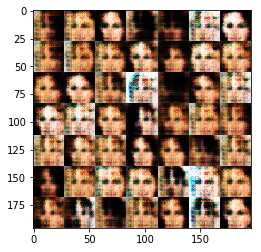

Epoch 1/1... Discriminator Loss: 0.5048... Generator Loss: 2.4846
Epoch 1/1... Discriminator Loss: 0.5256... Generator Loss: 1.8756
Epoch 1/1... Discriminator Loss: 0.5097... Generator Loss: 2.4358
Epoch 1/1... Discriminator Loss: 0.4869... Generator Loss: 2.3472
Epoch 1/1... Discriminator Loss: 0.4700... Generator Loss: 2.8313
Epoch 1/1... Discriminator Loss: 0.5103... Generator Loss: 2.4305
Epoch 1/1... Discriminator Loss: 0.4658... Generator Loss: 3.6170
Epoch 1/1... Discriminator Loss: 0.6791... Generator Loss: 2.0731
Epoch 1/1... Discriminator Loss: 0.6303... Generator Loss: 1.7419
Epoch 1/1... Discriminator Loss: 0.5208... Generator Loss: 2.1111


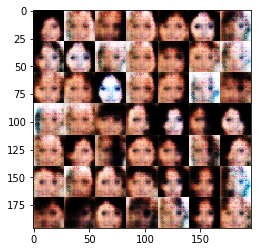

Epoch 1/1... Discriminator Loss: 0.4998... Generator Loss: 2.6491
Epoch 1/1... Discriminator Loss: 0.5069... Generator Loss: 2.3419
Epoch 1/1... Discriminator Loss: 0.4640... Generator Loss: 2.9626
Epoch 1/1... Discriminator Loss: 0.4161... Generator Loss: 3.4742
Epoch 1/1... Discriminator Loss: 0.4139... Generator Loss: 3.3209
Epoch 1/1... Discriminator Loss: 0.4316... Generator Loss: 2.6971
Epoch 1/1... Discriminator Loss: 0.4198... Generator Loss: 3.0200
Epoch 1/1... Discriminator Loss: 0.4188... Generator Loss: 2.7652
Epoch 1/1... Discriminator Loss: 0.4108... Generator Loss: 3.0873
Epoch 1/1... Discriminator Loss: 0.4601... Generator Loss: 2.5871


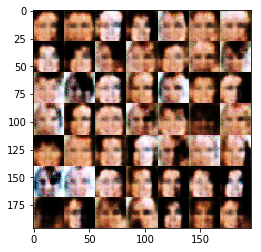

Epoch 1/1... Discriminator Loss: 0.5079... Generator Loss: 2.1411
Epoch 1/1... Discriminator Loss: 0.4069... Generator Loss: 3.3655
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 4.5992
Epoch 1/1... Discriminator Loss: 0.4857... Generator Loss: 2.3122
Epoch 1/1... Discriminator Loss: 0.6124... Generator Loss: 1.7870
Epoch 1/1... Discriminator Loss: 0.4323... Generator Loss: 3.1426
Epoch 1/1... Discriminator Loss: 0.4558... Generator Loss: 2.5172
Epoch 1/1... Discriminator Loss: 0.4325... Generator Loss: 2.9597
Epoch 1/1... Discriminator Loss: 0.4189... Generator Loss: 3.2457
Epoch 1/1... Discriminator Loss: 0.3865... Generator Loss: 3.8642


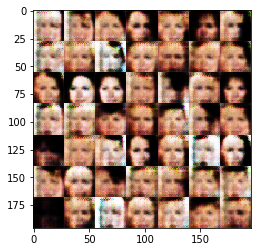

Epoch 1/1... Discriminator Loss: 0.4125... Generator Loss: 3.3318
Epoch 1/1... Discriminator Loss: 0.4508... Generator Loss: 2.6707
Epoch 1/1... Discriminator Loss: 0.4487... Generator Loss: 2.5464
Epoch 1/1... Discriminator Loss: 0.4557... Generator Loss: 2.5709
Epoch 1/1... Discriminator Loss: 0.4070... Generator Loss: 3.1984
Epoch 1/1... Discriminator Loss: 0.4345... Generator Loss: 2.7481
Epoch 1/1... Discriminator Loss: 0.4745... Generator Loss: 2.5595
Epoch 1/1... Discriminator Loss: 0.4950... Generator Loss: 2.3775
Epoch 1/1... Discriminator Loss: 0.4551... Generator Loss: 3.0370
Epoch 1/1... Discriminator Loss: 0.4306... Generator Loss: 3.3473


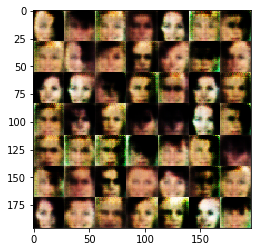

Epoch 1/1... Discriminator Loss: 0.4183... Generator Loss: 2.8140
Epoch 1/1... Discriminator Loss: 0.4461... Generator Loss: 2.9394
Epoch 1/1... Discriminator Loss: 0.4118... Generator Loss: 3.6834
Epoch 1/1... Discriminator Loss: 0.4274... Generator Loss: 3.0199
Epoch 1/1... Discriminator Loss: 0.4539... Generator Loss: 3.0606
Epoch 1/1... Discriminator Loss: 0.4172... Generator Loss: 2.9212
Epoch 1/1... Discriminator Loss: 0.5947... Generator Loss: 3.3499
Epoch 1/1... Discriminator Loss: 2.8363... Generator Loss: 5.6850
Epoch 1/1... Discriminator Loss: 0.5336... Generator Loss: 2.5117
Epoch 1/1... Discriminator Loss: 0.6365... Generator Loss: 1.7211


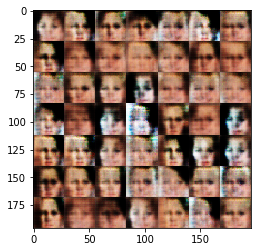

Epoch 1/1... Discriminator Loss: 0.4848... Generator Loss: 3.0557
Epoch 1/1... Discriminator Loss: 0.6584... Generator Loss: 1.8848
Epoch 1/1... Discriminator Loss: 0.5434... Generator Loss: 2.3626
Epoch 1/1... Discriminator Loss: 0.4670... Generator Loss: 2.9100
Epoch 1/1... Discriminator Loss: 0.4617... Generator Loss: 2.6056
Epoch 1/1... Discriminator Loss: 0.4772... Generator Loss: 2.7658
Epoch 1/1... Discriminator Loss: 0.5146... Generator Loss: 2.4365
Epoch 1/1... Discriminator Loss: 0.4677... Generator Loss: 3.2206
Epoch 1/1... Discriminator Loss: 0.5848... Generator Loss: 1.9467
Epoch 1/1... Discriminator Loss: 0.4107... Generator Loss: 3.5330


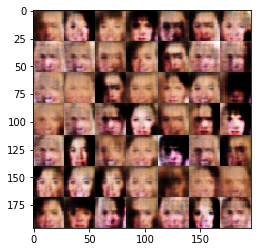

Epoch 1/1... Discriminator Loss: 0.4028... Generator Loss: 3.4766
Epoch 1/1... Discriminator Loss: 0.5671... Generator Loss: 2.1327
Epoch 1/1... Discriminator Loss: 0.4459... Generator Loss: 3.0959
Epoch 1/1... Discriminator Loss: 0.4028... Generator Loss: 4.0507
Epoch 1/1... Discriminator Loss: 0.4234... Generator Loss: 3.8732
Epoch 1/1... Discriminator Loss: 0.5943... Generator Loss: 1.7729
Epoch 1/1... Discriminator Loss: 0.5095... Generator Loss: 2.2529
Epoch 1/1... Discriminator Loss: 0.4569... Generator Loss: 2.6248
Epoch 1/1... Discriminator Loss: 0.5580... Generator Loss: 2.9660
Epoch 1/1... Discriminator Loss: 0.4712... Generator Loss: 3.0568


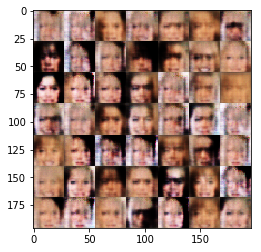

Epoch 1/1... Discriminator Loss: 0.4597... Generator Loss: 2.9151
Epoch 1/1... Discriminator Loss: 0.6282... Generator Loss: 1.6616
Epoch 1/1... Discriminator Loss: 0.5151... Generator Loss: 2.3671
Epoch 1/1... Discriminator Loss: 0.5927... Generator Loss: 1.9509
Epoch 1/1... Discriminator Loss: 0.5142... Generator Loss: 2.3355
Epoch 1/1... Discriminator Loss: 0.5454... Generator Loss: 2.0200
Epoch 1/1... Discriminator Loss: 0.4405... Generator Loss: 3.1521
Epoch 1/1... Discriminator Loss: 0.4595... Generator Loss: 2.5683
Epoch 1/1... Discriminator Loss: 0.4846... Generator Loss: 2.3787
Epoch 1/1... Discriminator Loss: 0.5147... Generator Loss: 2.3203


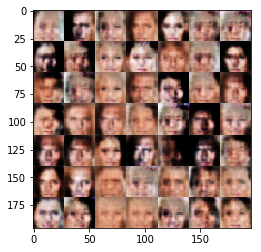

Epoch 1/1... Discriminator Loss: 0.4979... Generator Loss: 2.2435
Epoch 1/1... Discriminator Loss: 0.4544... Generator Loss: 3.1509
Epoch 1/1... Discriminator Loss: 0.5423... Generator Loss: 2.2282
Epoch 1/1... Discriminator Loss: 0.5225... Generator Loss: 2.8931
Epoch 1/1... Discriminator Loss: 0.5412... Generator Loss: 2.1416
Epoch 1/1... Discriminator Loss: 0.4912... Generator Loss: 2.3525
Epoch 1/1... Discriminator Loss: 0.4766... Generator Loss: 2.1773
Epoch 1/1... Discriminator Loss: 0.4422... Generator Loss: 2.8692
Epoch 1/1... Discriminator Loss: 0.4873... Generator Loss: 2.3137
Epoch 1/1... Discriminator Loss: 0.4762... Generator Loss: 2.2493


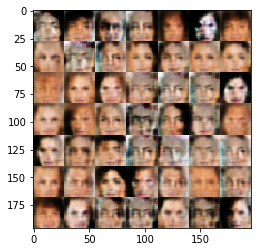

Epoch 1/1... Discriminator Loss: 0.4852... Generator Loss: 2.3029
Epoch 1/1... Discriminator Loss: 3.3223... Generator Loss: 6.0773
Epoch 1/1... Discriminator Loss: 1.0181... Generator Loss: 3.3447
Epoch 1/1... Discriminator Loss: 0.7787... Generator Loss: 1.6523
Epoch 1/1... Discriminator Loss: 1.0073... Generator Loss: 1.1491
Epoch 1/1... Discriminator Loss: 0.5252... Generator Loss: 2.3675
Epoch 1/1... Discriminator Loss: 0.6949... Generator Loss: 1.3688
Epoch 1/1... Discriminator Loss: 0.5361... Generator Loss: 2.0093
Epoch 1/1... Discriminator Loss: 0.4978... Generator Loss: 2.6980
Epoch 1/1... Discriminator Loss: 0.4378... Generator Loss: 2.8840


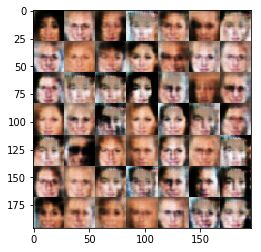

Epoch 1/1... Discriminator Loss: 0.5432... Generator Loss: 2.1297
Epoch 1/1... Discriminator Loss: 0.5132... Generator Loss: 2.4267
Epoch 1/1... Discriminator Loss: 0.4496... Generator Loss: 3.2274
Epoch 1/1... Discriminator Loss: 0.4585... Generator Loss: 2.9642
Epoch 1/1... Discriminator Loss: 0.4059... Generator Loss: 3.5535
Epoch 1/1... Discriminator Loss: 0.5185... Generator Loss: 2.4878
Epoch 1/1... Discriminator Loss: 0.4428... Generator Loss: 3.3568
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 3.3479
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 0.5930... Generator Loss: 2.3494


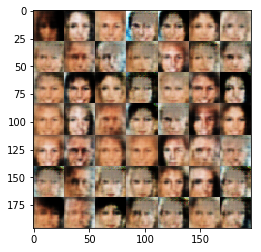

Epoch 1/1... Discriminator Loss: 0.5664... Generator Loss: 2.1370
Epoch 1/1... Discriminator Loss: 0.4843... Generator Loss: 2.5230
Epoch 1/1... Discriminator Loss: 0.7806... Generator Loss: 1.5121
Epoch 1/1... Discriminator Loss: 0.4595... Generator Loss: 2.4995
Epoch 1/1... Discriminator Loss: 0.4892... Generator Loss: 2.8003
Epoch 1/1... Discriminator Loss: 0.5307... Generator Loss: 2.2443
Epoch 1/1... Discriminator Loss: 0.5424... Generator Loss: 1.9680
Epoch 1/1... Discriminator Loss: 0.4630... Generator Loss: 2.3243
Epoch 1/1... Discriminator Loss: 0.4239... Generator Loss: 3.7878
Epoch 1/1... Discriminator Loss: 0.4648... Generator Loss: 2.8802


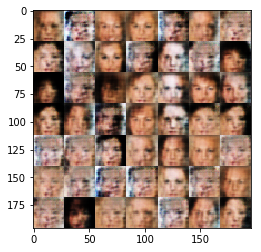

Epoch 1/1... Discriminator Loss: 0.5079... Generator Loss: 2.3954
Epoch 1/1... Discriminator Loss: 0.4639... Generator Loss: 2.7290
Epoch 1/1... Discriminator Loss: 0.5145... Generator Loss: 2.2659
Epoch 1/1... Discriminator Loss: 0.4486... Generator Loss: 3.0407
Epoch 1/1... Discriminator Loss: 0.4629... Generator Loss: 3.2624
Epoch 1/1... Discriminator Loss: 0.5518... Generator Loss: 2.0447
Epoch 1/1... Discriminator Loss: 0.4048... Generator Loss: 3.2779
Epoch 1/1... Discriminator Loss: 0.4964... Generator Loss: 2.4084
Epoch 1/1... Discriminator Loss: 0.4913... Generator Loss: 2.3989
Epoch 1/1... Discriminator Loss: 0.4995... Generator Loss: 2.4793


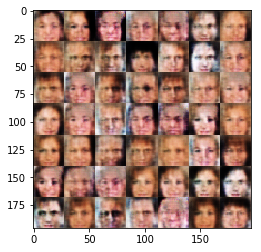

Epoch 1/1... Discriminator Loss: 0.4717... Generator Loss: 2.8300
Epoch 1/1... Discriminator Loss: 0.4884... Generator Loss: 2.4508
Epoch 1/1... Discriminator Loss: 0.5140... Generator Loss: 2.2949
Epoch 1/1... Discriminator Loss: 0.4802... Generator Loss: 2.6460
Epoch 1/1... Discriminator Loss: 0.5154... Generator Loss: 2.4834
Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 3.6818
Epoch 1/1... Discriminator Loss: 0.8892... Generator Loss: 1.0957
Epoch 1/1... Discriminator Loss: 0.5997... Generator Loss: 2.4326
Epoch 1/1... Discriminator Loss: 0.4638... Generator Loss: 3.7898
Epoch 1/1... Discriminator Loss: 0.7477... Generator Loss: 1.3360


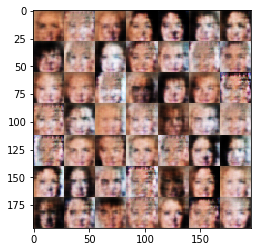

Epoch 1/1... Discriminator Loss: 0.4804... Generator Loss: 3.1280
Epoch 1/1... Discriminator Loss: 0.5511... Generator Loss: 3.1407
Epoch 1/1... Discriminator Loss: 0.5077... Generator Loss: 2.3198
Epoch 1/1... Discriminator Loss: 0.4411... Generator Loss: 2.6972
Epoch 1/1... Discriminator Loss: 0.4770... Generator Loss: 2.6207
Epoch 1/1... Discriminator Loss: 0.4933... Generator Loss: 2.3576
Epoch 1/1... Discriminator Loss: 0.5210... Generator Loss: 2.6470
Epoch 1/1... Discriminator Loss: 0.5097... Generator Loss: 2.7860
Epoch 1/1... Discriminator Loss: 0.4332... Generator Loss: 3.3663
Epoch 1/1... Discriminator Loss: 0.6216... Generator Loss: 1.6198


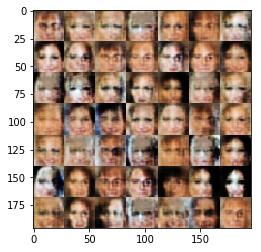

Epoch 1/1... Discriminator Loss: 0.4953... Generator Loss: 2.7254
Epoch 1/1... Discriminator Loss: 0.5800... Generator Loss: 1.9486
Epoch 1/1... Discriminator Loss: 0.4073... Generator Loss: 3.5518
Epoch 1/1... Discriminator Loss: 0.5442... Generator Loss: 2.0730
Epoch 1/1... Discriminator Loss: 0.5640... Generator Loss: 2.0450
Epoch 1/1... Discriminator Loss: 0.4995... Generator Loss: 2.3199
Epoch 1/1... Discriminator Loss: 0.4942... Generator Loss: 2.5023
Epoch 1/1... Discriminator Loss: 0.6204... Generator Loss: 1.8264
Epoch 1/1... Discriminator Loss: 0.5246... Generator Loss: 2.7493
Epoch 1/1... Discriminator Loss: 1.6585... Generator Loss: 6.0529


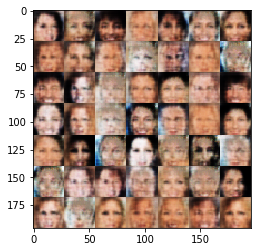

Epoch 1/1... Discriminator Loss: 0.8270... Generator Loss: 1.4097
Epoch 1/1... Discriminator Loss: 0.6017... Generator Loss: 3.0808
Epoch 1/1... Discriminator Loss: 0.5346... Generator Loss: 2.3995
Epoch 1/1... Discriminator Loss: 0.4821... Generator Loss: 2.9279
Epoch 1/1... Discriminator Loss: 0.4410... Generator Loss: 3.3314
Epoch 1/1... Discriminator Loss: 0.5128... Generator Loss: 2.3730
Epoch 1/1... Discriminator Loss: 0.4789... Generator Loss: 2.6597
Epoch 1/1... Discriminator Loss: 0.4673... Generator Loss: 2.9398
Epoch 1/1... Discriminator Loss: 0.6017... Generator Loss: 1.9679
Epoch 1/1... Discriminator Loss: 0.5056... Generator Loss: 2.4986


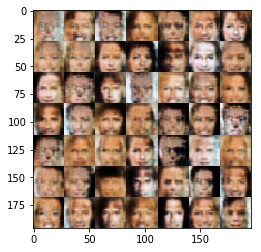

Epoch 1/1... Discriminator Loss: 0.5240... Generator Loss: 2.5334
Epoch 1/1... Discriminator Loss: 0.5077... Generator Loss: 2.1801
Epoch 1/1... Discriminator Loss: 0.4641... Generator Loss: 2.9188
Epoch 1/1... Discriminator Loss: 0.6238... Generator Loss: 2.0833
Epoch 1/1... Discriminator Loss: 0.4896... Generator Loss: 2.6789
Epoch 1/1... Discriminator Loss: 0.4207... Generator Loss: 3.7647
Epoch 1/1... Discriminator Loss: 0.4559... Generator Loss: 2.6739
Epoch 1/1... Discriminator Loss: 0.5404... Generator Loss: 2.2992
Epoch 1/1... Discriminator Loss: 0.5374... Generator Loss: 2.0375
Epoch 1/1... Discriminator Loss: 0.5056... Generator Loss: 2.4405


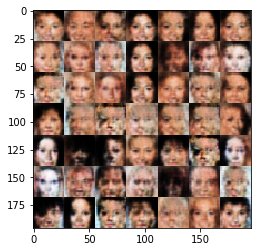

Epoch 1/1... Discriminator Loss: 0.4637... Generator Loss: 2.7638
Epoch 1/1... Discriminator Loss: 0.4724... Generator Loss: 2.6073
Epoch 1/1... Discriminator Loss: 0.5148... Generator Loss: 2.2113
Epoch 1/1... Discriminator Loss: 0.5513... Generator Loss: 2.1968
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 4.1983
Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 4.6818
Epoch 1/1... Discriminator Loss: 0.8195... Generator Loss: 1.4215
Epoch 1/1... Discriminator Loss: 0.7251... Generator Loss: 2.2342
Epoch 1/1... Discriminator Loss: 0.5320... Generator Loss: 2.7381
Epoch 1/1... Discriminator Loss: 0.5734... Generator Loss: 2.3229


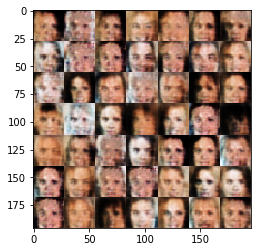

Epoch 1/1... Discriminator Loss: 0.5695... Generator Loss: 2.7645
Epoch 1/1... Discriminator Loss: 0.5070... Generator Loss: 2.0965
Epoch 1/1... Discriminator Loss: 0.4858... Generator Loss: 3.1617
Epoch 1/1... Discriminator Loss: 0.5473... Generator Loss: 2.5114
Epoch 1/1... Discriminator Loss: 0.6081... Generator Loss: 1.9580
Epoch 1/1... Discriminator Loss: 0.5241... Generator Loss: 2.2062
Epoch 1/1... Discriminator Loss: 0.5640... Generator Loss: 1.9862
Epoch 1/1... Discriminator Loss: 0.6250... Generator Loss: 3.3473
Epoch 1/1... Discriminator Loss: 0.4525... Generator Loss: 2.6137
Epoch 1/1... Discriminator Loss: 0.5389... Generator Loss: 2.2144


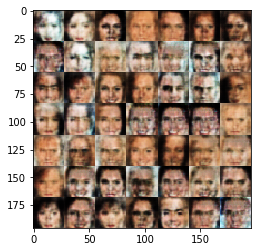

Epoch 1/1... Discriminator Loss: 0.6233... Generator Loss: 1.7079
Epoch 1/1... Discriminator Loss: 0.5036... Generator Loss: 2.8776
Epoch 1/1... Discriminator Loss: 0.4695... Generator Loss: 2.7781
Epoch 1/1... Discriminator Loss: 0.5943... Generator Loss: 2.9344


In [31]:
batch_size = 63
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.